In [22]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sn
import matplotlib.pyplot as plt

In [34]:
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression  # Example classifier

metrics = {
    'Fold': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'Specificity': [],
    'F1-score': []
}

for i in range(5):
    predictions = pd.read_parquet(f'{project_name}/mil/0000{i}-clam_sb-category/predictions.parquet')
    predictions['y_pred'] = np.where(predictions['y_pred0']>0.5, 0, 1)

    y_test, y_pred = predictions['y_true'], predictions['y_pred']

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    metrics['Fold'].append(i+1)
    metrics['Accuracy'].append(accuracy)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['Specificity'].append(specificity)
    metrics['F1-score'].append(f1)

# Convert metrics to pandas DataFrame
metrics_df = pd.DataFrame(metrics)
mean = pd.DataFrame(metrics_df.mean(axis=0)).T
mean['Fold'] = 'Mean'

metrics_df = pd.concat([metrics_df, mean])

# Display the metrics table
print(metrics_df)


   Fold  Accuracy  Precision  Recall  Specificity  F1-score
0     1  1.000000       1.00    1.00     1.000000  1.000000
1     2  0.857143       0.80    1.00     0.666667  0.888889
2     3  1.000000       1.00    1.00     1.000000  1.000000
3     4  1.000000       1.00    1.00     1.000000  1.000000
4     5  0.857143       1.00    0.75     1.000000  0.857143
0  Mean  0.942857       0.96    0.95     0.933333  0.949206


In [17]:
project_name = 'slideflow_Lyon_TCGA'

df = pd.DataFrame()
for i in range(5):
    predictions = pd.read_parquet(f'{project_name}/mil/0000{i}-clam_sb-category/predictions.parquet')
    predictions['y_pred'] = np.where(predictions['y_pred0']>0.5, 0, 1)

    y_true, y_pred = predictions['y_true'], predictions['y_pred']

    cr = classification_report(y_true, y_pred, target_names=['CTR', 'YO'], zero_division=0.0, output_dict=True)

    # Convert the report dictionary to a DataFrame
    report_df = pd.DataFrame(cr).transpose()
    report_df = report_df.loc[['CTR', 'YO'], ['precision', 'recall', 'f1-score']]
    report_df['Label'] = report_df.index
    report_df['Fold'] = [i+1, i+1]

    df = pd.concat([df, report_df], axis=0, ignore_index=True)

In [18]:
df

,precision,recall,f1-score,Label,Fold
0,1.00,1.000000,1.000000,CTR,1
1,1.00,1.000000,1.000000,YO,1
2,1.00,0.666667,0.800000,CTR,2
3,0.80,1.000000,0.888889,YO,2
4,1.00,1.000000,1.000000,CTR,3
5,1.00,1.000000,1.000000,YO,3
6,1.00,1.000000,1.000000,CTR,4
7,1.00,1.000000,1.000000,YO,4
8,0.75,1.000000,0.857143,CTR,5
9,1.00,0.750000,0.857143,YO,5


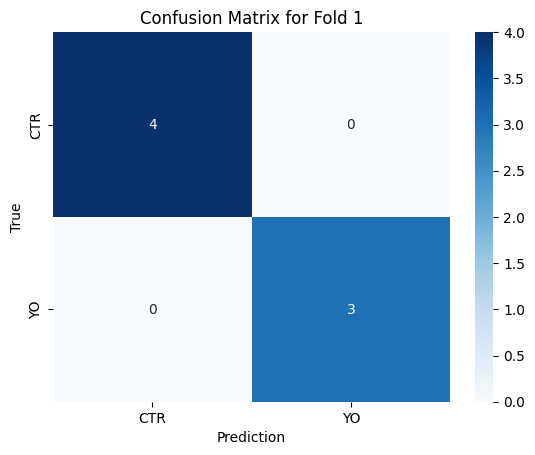

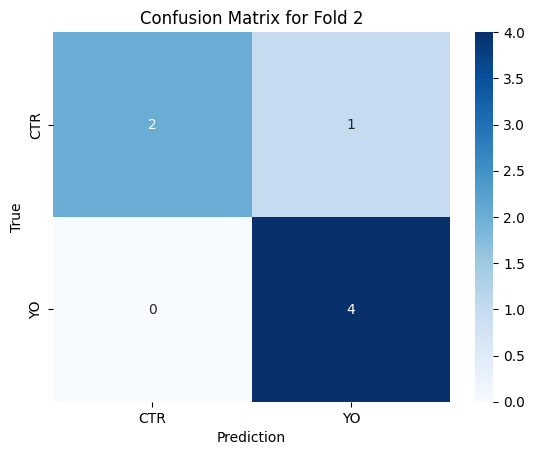

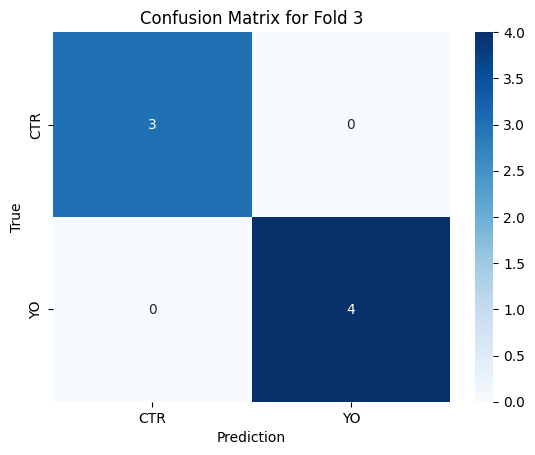

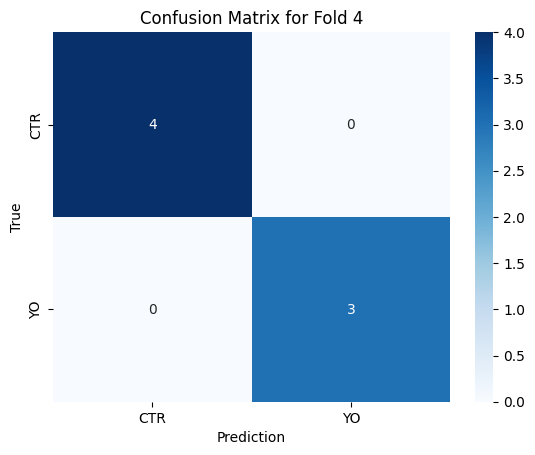

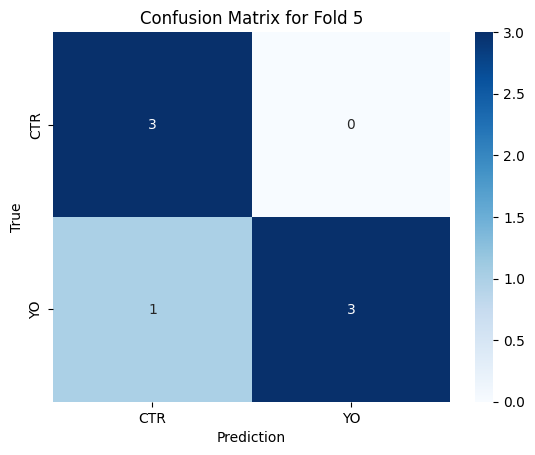

In [24]:
for i in range(5):
    predictions = pd.read_parquet(f'{project_name}/mil/0000{i}-clam_sb-category/predictions.parquet')
    predictions['y_pred'] = np.where(predictions['y_pred0']>0.5, 0, 1)
    tn, fp, fn, tp = confusion_matrix(predictions['y_true'], predictions['y_pred']).ravel()
    # s = tn / (tn + fp)

    classes = ['CTR', 'YO']
    cm = pd.crosstab(predictions['y_true'], predictions['y_pred'], rownames=['True'], colnames=['Prediction'])

    sn.heatmap(cm, annot=True, xticklabels = classes, yticklabels = classes, cmap='Blues')
    plt.title(f'Confusion Matrix for Fold {i+1}')
    
    plt.savefig(f'figures/Lyon_TCGA/confusion_matrix_dataset{i}.png', dpi=1200)
    # plt.savefig(f'figures/Lyon_TCGA/confusion_matrix_dataset{i}.svg', format = 'svg', dpi=1200)

    plt.show()

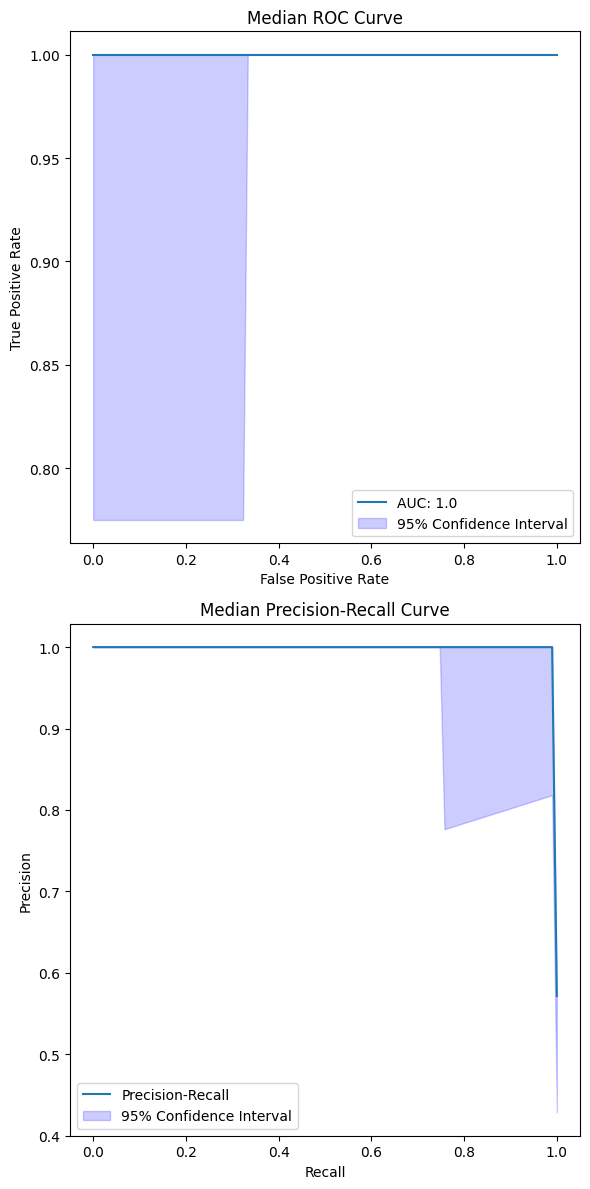

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.model_selection import KFold

# Initialize lists to store TPR, FPR, precision, and recall values for each fold
tpr_interpolated_list = []
fpr_points = np.linspace(0, 1, 100)
precision_interpolated_list = []
recall_points = np.linspace(0, 1, 100)

# Loop through each fold
for i in range(5):
    # Read predictions
    predictions = pd.read_parquet(f'{project_name}/mil/0000{i}-clam_sb-category/predictions.parquet')
    
    # True labels and predicted probabilities
    y_true = predictions['y_true']
    y_scores = predictions['y_pred1']

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    tpr_interpolated = np.interp(fpr_points, fpr, tpr)
    tpr_interpolated_list.append(tpr_interpolated)

    # Calculate Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    precision_interpolated = np.interp(recall_points, recall[::-1], precision[::-1])
    precision_interpolated_list.append(precision_interpolated)

# Convert lists to DataFrames for easy aggregation
tpr_interpolated_df = pd.DataFrame(tpr_interpolated_list)
precision_interpolated_df = pd.DataFrame(precision_interpolated_list)

# Compute the median and confidence intervals
tpr_median = tpr_interpolated_df.median(axis=0)
tpr_lower = tpr_interpolated_df.quantile(0.025, axis=0)
tpr_upper = tpr_interpolated_df.quantile(0.975, axis=0)

precision_median = precision_interpolated_df.median(axis=0)
precision_lower = precision_interpolated_df.quantile(0.025, axis=0)
precision_upper = precision_interpolated_df.quantile(0.975, axis=0)

area = auc(fpr_points, tpr_median)

# Plot the ROC and Precision-Recall curves with confidence intervals
fig, ax = plt.subplots(2, 1, figsize=(6, 12))

# ROC Curve
ax[0].plot(fpr_points, tpr_median, label=f'AUC: {round(area, 2)}')
ax[0].fill_between(fpr_points, tpr_lower, tpr_upper, color='b', alpha=0.2, label='95% Confidence Interval')
ax[0].set_title('Median ROC Curve')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend()

# Precision-Recall Curve
ax[1].plot(recall_points, precision_median, label='Precision-Recall')
ax[1].fill_between(recall_points, precision_lower, precision_upper, color='b', alpha=0.2, label='95% Confidence Interval')
ax[1].set_title('Median Precision-Recall Curve')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].legend()

plt.tight_layout()

plt.savefig(f'figures/Lyon_TCGA/roc_precision.png', dpi=1200)
# plt.savefig(f'figures/Lyon_TCGA/roc_precision.svg', format = 'svg', dpi=1200)


plt.show()


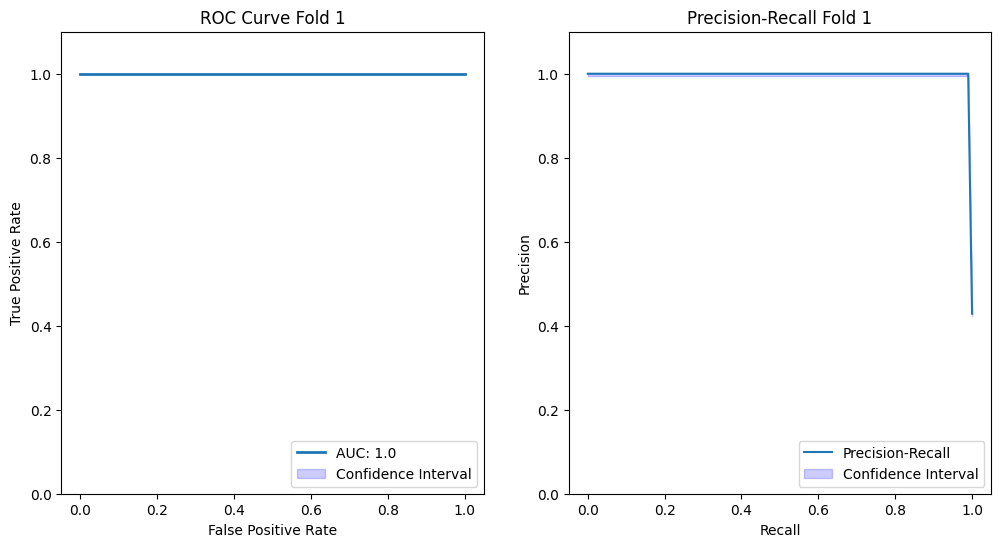

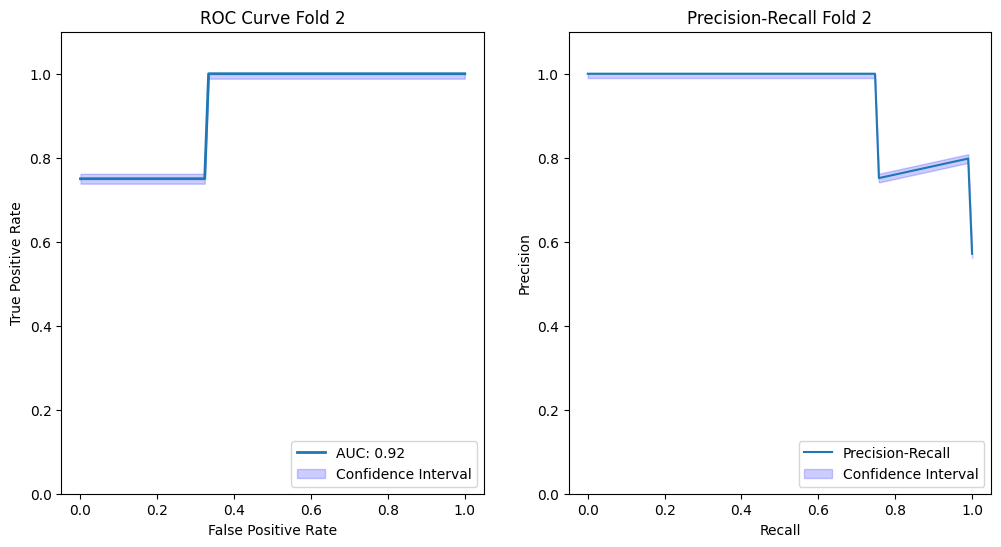

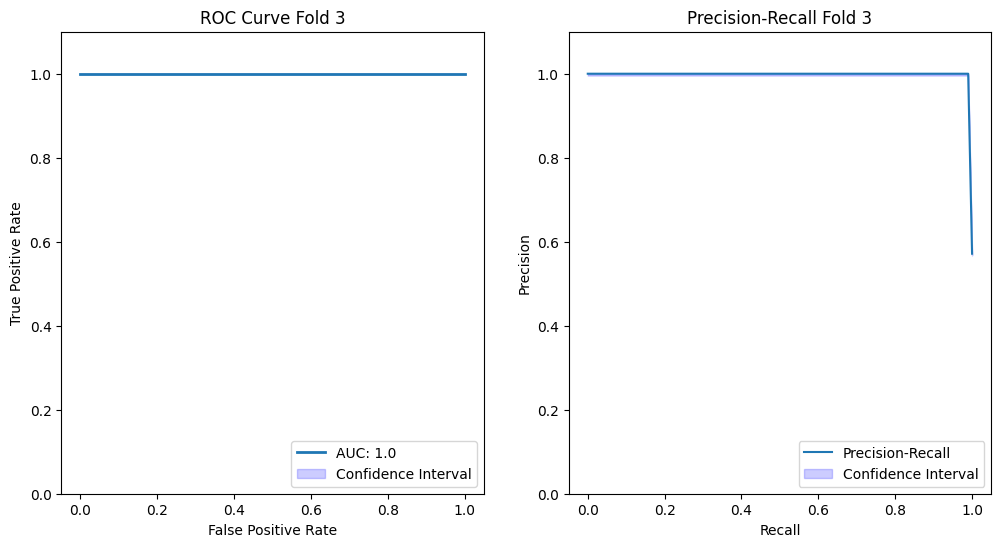

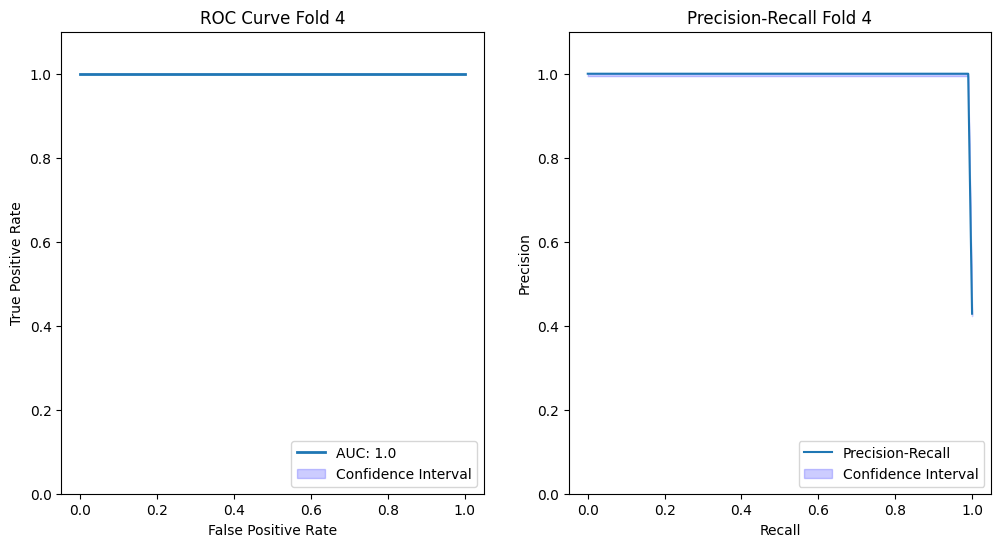

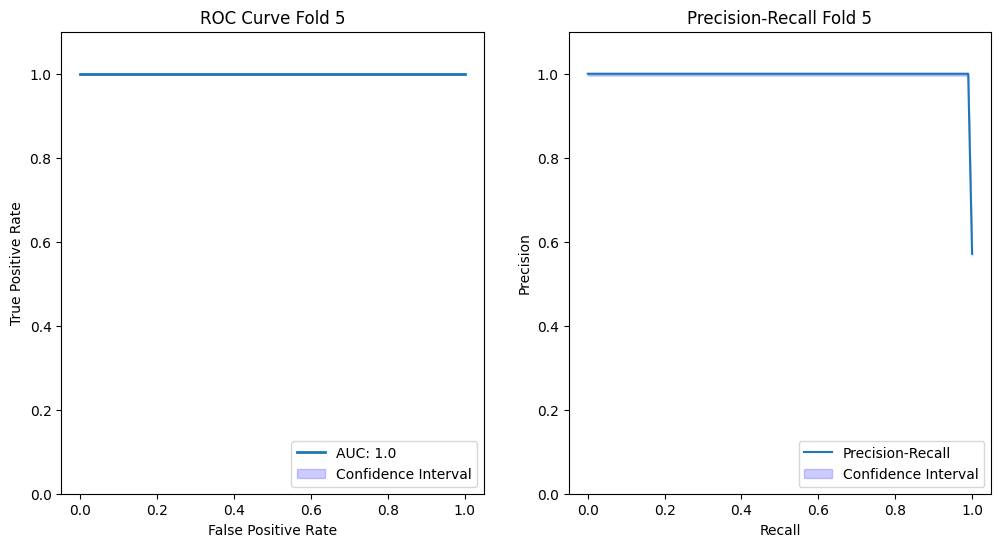

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix
from scipy.stats import sem

for i in range(5):
    # Read predictions
    predictions = pd.read_parquet(f'{project_name}/mil/0000{i}-clam_sb-category/predictions.parquet')
    
    # True labels and predicted probabilities
    y_true = predictions['y_true']
    y_scores = predictions['y_pred1']

    # Calculate ROC curve
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)
    area = auc(fpr, tpr)
    
    # Interpolate TPR values at common FPR points
    fpr_points = np.linspace(0, 1, 100)
    tpr_interpolated = np.interp(fpr_points, fpr, tpr)

    # Calculate Precision-Recall curve
    precision, recall, pr_thresholds = precision_recall_curve(y_true, y_scores)
    
    # Interpolate precision values at common recall points
    recall_points = np.linspace(0, 1, 100)
    precision_interpolated = np.interp(recall_points, recall[::-1], precision[::-1])

    # Compute confidence intervals for TPR and precision using standard error of the mean (SEM)
    tpr_sem = sem(tpr_interpolated)
    precision_sem = sem(precision_interpolated)
    
    tpr_lower = tpr_interpolated - tpr_sem
    tpr_upper = tpr_interpolated + tpr_sem

    tpr_lower = np.maximum(tpr_lower, 0)
    tpr_upper = np.minimum(tpr_upper, 1)

    precision_lower = precision_interpolated - precision_sem
    precision_upper = precision_interpolated + precision_sem

    precision_lower = np.maximum(precision_lower, 0)
    precision_upper = np.minimum(precision_upper, 1)


    # Plot ROC and Precision-Recall curves with confidence intervals for the fold
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    axes = ax.flatten()

    # ROC Curve
    axes[0].plot(fpr_points, tpr_interpolated, label=f'AUC: {round(area,2)}', linewidth=2)
    axes[0].fill_between(fpr_points, tpr_lower, tpr_upper, color='b', alpha=0.2, label='Confidence Interval')
    axes[0].set_title(f'ROC Curve Fold {i+1}')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_ylim(0, 1.1)  # Set y-axis limit from 0 to 1
    axes[0].legend(loc='lower right')

    # Precision-Recall Curve
    axes[1].plot(recall_points, precision_interpolated, label=f'Precision-Recall')
    axes[1].fill_between(recall_points, precision_lower, precision_upper, color='b', alpha=0.2, label='Confidence Interval')
    axes[1].set_title(f'Precision-Recall Fold {i+1}')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_ylim(0, 1.1)  # Set y-axis limit from 0 to 1
    axes[1].legend(loc='lower right')

    plt.savefig(f'figures/Lyon_TCGA/roc_precision_dataset{i}.png', dpi=1200)
    # plt.savefig(f'figures/Lyon_TCGA/roc_precision_dataset{i}.svg', format = 'svg', dpi=1200)


    plt.show()

In [1]:
df = pd.read_csv('annotations/annotations_Lyon_TCGA_37_dataset.csv')
df.rename(columns={f'dataset{i}': f'Fold {i+1}' for i in range(5)}, inplace=True)
df.drop('slide', axis=1, inplace=True)
df.head()